<a href="https://colab.research.google.com/github/ahzaidy/Programs/blob/main/CPSC_5410_HW1_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training with Dropout Rate: 0.3
Epoch 10/200, Loss: 0.6618, Learning Rate: 0.001000
Epoch 20/200, Loss: 0.3474, Learning Rate: 0.001000
Epoch 30/200, Loss: 0.3105, Learning Rate: 0.001000
Epoch 40/200, Loss: 0.2386, Learning Rate: 0.001000
Epoch 50/200, Loss: 0.2403, Learning Rate: 0.001000
Epoch 60/200, Loss: 0.2328, Learning Rate: 0.001000
Epoch 70/200, Loss: 0.2135, Learning Rate: 0.001000
Epoch 80/200, Loss: 0.1911, Learning Rate: 0.001000
Epoch 90/200, Loss: 0.1608, Learning Rate: 0.001000
Epoch 100/200, Loss: 0.1721, Learning Rate: 0.001000
Epoch 110/200, Loss: 0.1789, Learning Rate: 0.000500
Epoch 120/200, Loss: 0.1597, Learning Rate: 0.000250
Epoch 130/200, Loss: 0.1630, Learning Rate: 0.000250
Epoch 140/200, Loss: 0.1663, Learning Rate: 0.000125
Epoch 150/200, Loss: 0.1691, Learning Rate: 0.000063
Epoch 160/200, Loss: 0.1802, Learning Rate: 0.000031
Epoch 170/200, Loss: 0.1650, Learning Rate: 0.000016
Epoch 180/200, Loss: 0.1686, Learning Rate: 0.000008
Epoch 190/200, Loss: 0.

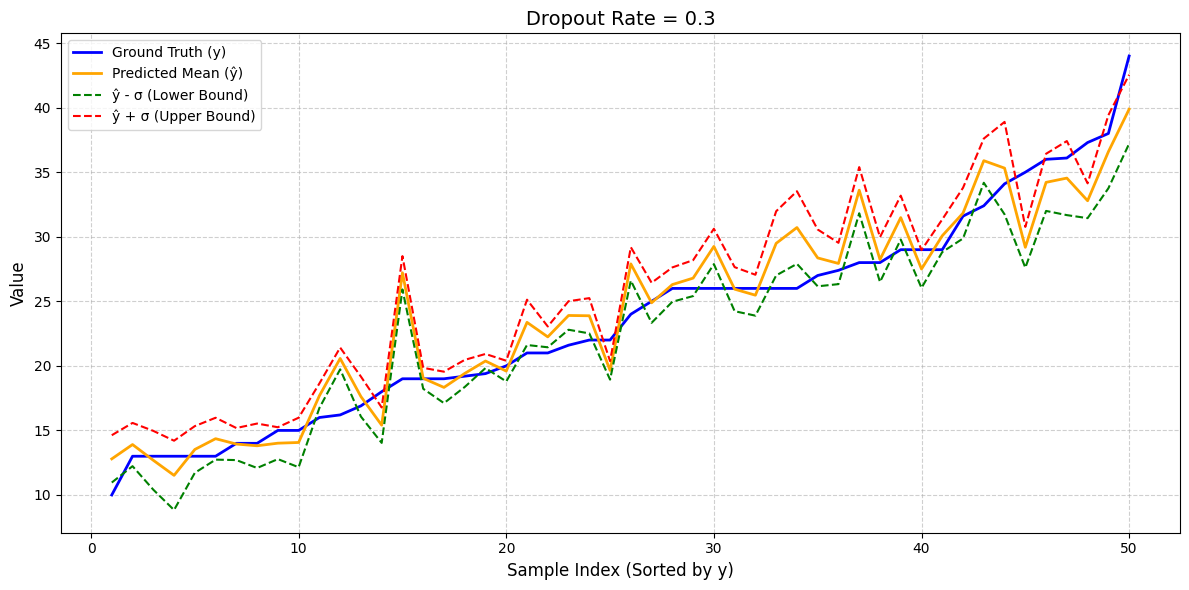

Training with Dropout Rate: 0.5
Epoch 10/200, Loss: 0.6614, Learning Rate: 0.001000
Epoch 20/200, Loss: 0.3872, Learning Rate: 0.001000
Epoch 30/200, Loss: 0.3332, Learning Rate: 0.001000
Epoch 40/200, Loss: 0.3196, Learning Rate: 0.001000
Epoch 50/200, Loss: 0.2865, Learning Rate: 0.001000
Epoch 60/200, Loss: 0.2667, Learning Rate: 0.000500
Epoch 70/200, Loss: 0.2403, Learning Rate: 0.000500
Epoch 80/200, Loss: 0.2995, Learning Rate: 0.000250
Epoch 90/200, Loss: 0.2767, Learning Rate: 0.000125
Epoch 100/200, Loss: 0.2384, Learning Rate: 0.000063
Epoch 110/200, Loss: 0.2472, Learning Rate: 0.000063
Epoch 120/200, Loss: 0.2331, Learning Rate: 0.000031
Epoch 130/200, Loss: 0.2414, Learning Rate: 0.000016
Epoch 140/200, Loss: 0.2668, Learning Rate: 0.000008
Epoch 150/200, Loss: 0.2502, Learning Rate: 0.000004
Epoch 160/200, Loss: 0.2747, Learning Rate: 0.000002
Epoch 170/200, Loss: 0.2603, Learning Rate: 0.000001
Epoch 180/200, Loss: 0.2597, Learning Rate: 0.000000
Epoch 190/200, Loss: 0.

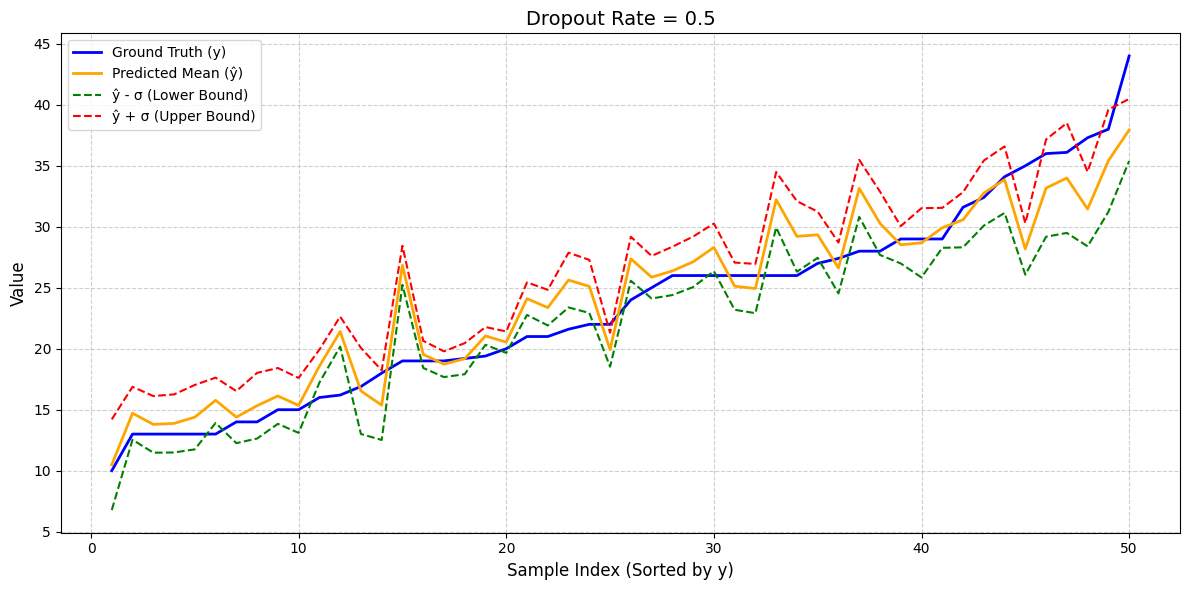

In [4]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

file_path = "https://raw.githubusercontent.com/ahzaidy/Programs/refs/heads/main/LibSVM-mpg.txt"

# Load the dataset using pandas
def load_data(file_path):
    data = pd.read_table(file_path, delim_whitespace=True, header=None)

    if data.shape[1] != 8:
        raise ValueError(f"Expected 8 columns (1 target + 7 features), but got {data.shape[1]} columns.")

    y = data.iloc[:, 0]  # Target (first column)
    X = data.iloc[:, 1:]  # Features (remaining columns)
    return X, y

# Define MLP model with Dropout
class MLPWithDropout(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(MLPWithDropout, self).__init__()
        # First fully connected layer
        self.fc1 = nn.Linear(input_size, hidden_size)
        # First dropout layer to prevent overfitting
        self.dropout1 = nn.Dropout(dropout_rate)

        # Second fully connected layer
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        # Second dropout layer
        self.dropout2 = nn.Dropout(dropout_rate)

        # Output layer with a single neuron for regression or binary classification
        self.fc3 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Apply the first fully connected layer followed by ReLU activation
        x = torch.relu(self.fc1(x))
        # Apply dropout to reduce overfitting
        x = self.dropout1(x)

        # Apply the second fully connected layer followed by ReLU activation
        x = torch.relu(self.fc2(x))
        # Apply second dropout layer
        x = self.dropout2(x)

        # Apply the final fully connected layer (output layer)
        x = self.fc3(x)

        # Return the output (raw scores/logits)
        return x

# Train the model
def train_model(model, X_train, y_train, epochs, lr):
    # Define the loss function (Mean Squared Error for regression tasks)
    criterion = nn.MSELoss()

    # Define the optimizer (Adam optimizer for adaptive learning rate updates)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Learning rate scheduler: reduces learning rate when loss stops improving
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)

    # Training loop
    for epoch in range(epochs):
        model.train()  # Set model to training mode

        optimizer.zero_grad()  # Clear previous gradients

        outputs = model(X_train)  # Forward pass: compute model predictions
        loss = criterion(outputs, y_train)  # Compute loss

        loss.backward()  # Backpropagation: compute gradients
        optimizer.step()  # Update model parameters

        scheduler.step(loss)  # Adjust learning rate based on loss trend

        # Print training progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            current_lr = scheduler.optimizer.param_groups[0]['lr']  # Get current learning rate
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}, Learning Rate: {current_lr:.6f}")


# Monte-Carlo Dropout Testing
def monte_carlo_testing(model, X_test, num_passes):
    # Keep the model in training mode to enable dropout during inference
    model.train()

    predictions = []  # List to store predictions from multiple forward passes

    # Perform multiple forward passes through the model
    for _ in range(num_passes):
        preds = model(X_test).detach().squeeze()  # Get model predictions, detach from computation graph
        predictions.append(preds.tolist())  # Store predictions as a list

    # Convert predictions into a DataFrame for easier statistical computation
    predictions_df = pd.DataFrame(predictions)

    # Compute the mean prediction for each sample
    means = predictions_df.mean(axis=0)
    # Compute the standard deviation (uncertainty) for each sample
    stds = predictions_df.std(axis=0)

    # Print standard deviation for each test sample to observe uncertainty
    for idx, std in stds.items():
        print(f"Sample {idx + 1}: Standard Deviation = {std:.4f}")

    # Return the mean predictions and associated uncertainties
    return means, stds


# Plot the results
def plot_results(y_true, y_mean, y_std, title):
    # Sort true values and rearrange predictions accordingly for better visualization
    sorted_indices = y_true.sort_values().index  # Get sorted indices based on true values
    y_true_sorted = y_true.loc[sorted_indices]  # Sort true values
    y_mean_sorted = y_mean.loc[sorted_indices]  # Sort predicted means accordingly
    y_std_sorted = y_std.loc[sorted_indices]  # Sort standard deviations accordingly

    # Compute the uncertainty bounds (mean ± standard deviation)
    lower_bound = y_mean_sorted - y_std_sorted
    upper_bound = y_mean_sorted + y_std_sorted

    # Create the plot
    plt.figure(figsize=(12, 6))

    # Plot the ground truth values (actual y values)
    plt.plot(range(1, len(y_true_sorted) + 1), y_true_sorted,
             label="Ground Truth (y)", color="blue", linewidth=2)

    # Plot the predicted mean values
    plt.plot(range(1, len(y_mean_sorted) + 1), y_mean_sorted,
             label="Predicted Mean (ŷ)", color="orange", linewidth=2)

    # Plot the lower uncertainty bound (ŷ - σ)
    plt.plot(range(1, len(lower_bound) + 1), lower_bound,
             label="ŷ - σ (Lower Bound)", linestyle="--", color="green", linewidth=1.5)

    # Plot the upper uncertainty bound (ŷ + σ)
    plt.plot(range(1, len(upper_bound) + 1), upper_bound,
             label="ŷ + σ (Upper Bound)", linestyle="--", color="red", linewidth=1.5)

    # Add legend to explain different lines in the plot
    plt.legend(loc="upper left", fontsize=10)

    # Label the axes
    plt.xlabel("Sample Index (Sorted by y)", fontsize=12)
    plt.ylabel("Value", fontsize=12)

    # Set the title of the plot
    plt.title(title, fontsize=14)

    # Add grid for better readability
    plt.grid(True, linestyle="--", alpha=0.6)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Display the plot
    plt.show()

# Main script
if __name__ == "__main__":
    try:
        # Load the dataset from the specified file path
        X, y = load_data(file_path)

        # Normalize features using StandardScaler (zero mean, unit variance)
        scaler_X = StandardScaler()
        X = pd.DataFrame(scaler_X.fit_transform(X))  # Transform X and convert back to DataFrame

        # Normalize target variable y using StandardScaler
        scaler_y = StandardScaler()
        y = pd.Series(scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten())  # Flatten after transformation

        # Split dataset into training and test sets (test set size = 50 samples)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=50, random_state=42, shuffle=True)

        # Convert Pandas DataFrames to PyTorch tensors for model training
        X_train = torch.tensor(X_train.values, dtype=torch.float32)
        X_test = torch.tensor(X_test.values, dtype=torch.float32)
        y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)  # Reshape for compatibility
        y_test = torch.tensor(y_test.values, dtype=torch.float32)

        # Train and evaluate the model for different dropout rates (0.3 and 0.5)
        for dropout_rate in [0.3, 0.5]:
            print(f"Training with Dropout Rate: {dropout_rate}")

            # Initialize the MLP model with the given dropout rate
            model = MLPWithDropout(input_size=7, hidden_size=64, dropout_rate=dropout_rate)

            # Train the model with the training data
            train_model(model, X_train, y_train, epochs=200, lr=0.001)

            # Perform Monte-Carlo Dropout Testing to estimate prediction uncertainty
            y_mean, y_std = monte_carlo_testing(model, X_test, num_passes=10)

            # Convert test labels and predictions back to original scale
            y_test_original = pd.Series(scaler_y.inverse_transform(y_test.view(-1, 1)).flatten())
            y_mean_original = pd.Series(scaler_y.inverse_transform(y_mean.values.reshape(-1, 1)).flatten())

            # Convert standard deviation predictions back to original scale
            y_std_original = pd.Series(
                scaler_y.inverse_transform((y_mean.values + y_std.values).reshape(-1, 1)).flatten() - y_mean_original
            )

            # Plot results to visualize predictions with uncertainty bounds
            plot_results(y_test_original, y_mean_original, y_std_original, title=f"Dropout Rate = {dropout_rate}")

    except Exception as e:
        # Catch and print any errors encountered during execution
        print(f"Error: {e}")

